# Kernel methods runthrough
#### by Alvin Zhang
##### Notes and examples based on Bishop's "Pattern Recognition and Machine Learning"

## Dual representation

We can represent a non-probabilistic model of regression with kernel functions. If we consider the regularized sum-of-squares error function for linear regression, $J(\vec{w})=\frac{1}{2}\sum_{n=1}^N(\vec{w}^T\vec{\phi}(\vec{x}_n)-t_n)^2+\frac{\lambda}{2}\vec{w}\vec{w}^T$, and find the minimum w.r.t. $\vec{w}$ by setting the derivative to 0, we get
$$\vec{w}=-\frac{1}{\lambda}\sum_{n=1}^N(\vec{w}^T\vec{\phi}(\vec{x}_n)-t_n)\vec{\phi}(\vec{x}_n)=\sum_{n=1}^Na_n\vec{\phi}(\vec{x}_n)=\Phi^T\vec{a}$$
where $\Phi$ is the design matrix and $\vec{a}$ is the vector $(a_1,...,a_N)^T$ where $a_n=-\frac{1}{\lambda}(\vec{w}^T\vec{\phi}(\vec{x}_n)-t_n)$. <br>
If we substitute this back into the original regularized sum-of-squares error function, we get
$$J(\vec{a})=\frac{1}{2}\vec{a}^T\mathbf{K}\mathbf{K}\vec{a}-\vec{a}^T\mathbf{K}\mathbf{t}+\frac{1}{2}\mathbf{t}^T\mathbf{t}+\frac{\lambda}{2}\vec{a}^T\mathbf{K}\vec{a}$$
where $\mathbf{K}=\Phi\Phi^T (\mathbf{K}_nm=\vec{\phi}(\vec{x}_n)^T\vec{\phi}(\vec{x}_m)=k(\vec{x}_n,\vec{x}_m)$ is the Gram matrix and $k(x,x')$ is a kernel function. <br>
The critical point w.r.t. $\vec{a}$ gives us
$$\vec{a}=(\mathbf{K}+\lambda\mathbf{I}_N)^{-1}\vec{t}$$
A new prediction is then given by 
$$y(\vec{x})=\vec{w}^T\vec{\phi}(\vec{x})=\vec{a}^T\Phi\vec{\phi}(\vec{x})=\vec{k}(\vec{x})^T(\mathbf{K}+\lambda\mathbf{I}_N)^{-1}\vec{t}$$
The kernel function can take many different forms. For example, $k(\vec{x},\vec{x}')=(\vec{x}^T\vec{x}'+c)^M$ is the polynomial kernel. The parameter $c$ trades off influence of higher-order vs. lower-order terms. Like we did with basis function, we're going to construct a kernel utility to make things more convenient.

In [1]:
import numpy as np


class KernelUtil:
    def __init__(self, kernel_name, **kwargs):
        """
        Initializes kernel utility.
        Args:
            kernel_name (string): either 'gaussian', 'polynomial', 'linear', 'combined'
            gamma (float): parameter for Gaussian kernel
            c (float): parameter for polynomial kernel
            M (float): parameter for polynomial kernel
        """
        self.kernel = self._kernel_chooser(kernel_name, kwargs)
    
    def _kernel_chooser(self, kernel_name, parameters):
        """
        Chooses kernel function.
        Args:
            kernel (string): either 'gaussian', 'polynomial', or 'linear'
            **kwargs: parameters for kernels
        Returns:
            k (function): kernel function
        """
        # Default parameters
        parameters.setdefault('gamma', 10)  # Gaussian
        parameters.setdefault('c', 1)  # Polynomial
        parameters.setdefault('M', 3)  # Polynomial
        parameters.setdefault('theta', [1, 4, 0, 0])  # Combined

        if kernel_name == 'gaussian':
            def k(x1, x2, gamma=parameters['gamma']):
                """
                Kernel function for Gaussian.
                Args:
                    x1 (float ndarray): single column vector input
                    x2 (float ndarray): single or multiple row vector inputs
                    gamma (float): inverse radius of influence
                Returns:
                    k_vec (float ndarray): Gaussian kernel applied to x1 and x2
                """
                N = x2.shape[0]
                k_vec = np.zeros((N, 1))
                for n in range(N):
                    k_vec[n] = np.exp(-gamma*np.linalg.norm(x1 - x2[[n]].T)**2)
                return k_vec
            return k
        if kernel_name == 'polynomial':
            def k(x1, x2, c=parameters['c'], M=parameters['M']):
                """
                Kernel function for polynomial.
                Args:
                    x1 (float ndarray): single column vector input
                    x2 (float ndarray): single or multiple row vector inputs
                    c (float): influence of higher-order versus lower-order terms
                    M (float): degree of polynomial
                Returns:
                    k_vec (float ndarray): polynomial kernel applied to x1 and x2
                """
                N = x2.shape[0]
                k_vec = np.zeros((N, 1))
                for n in range(N):
                    k_vec[n] = (c + x1.T.dot(x2[[n]].T))**M
                return k_vec
            return k
        if kernel_name == 'linear':
            def k(x1, x2):
                """
                Linear kernel
                Args:
                    x1 (float ndarray): single column vector input
                    x2 (float ndarray): single or multiple row vector inputs
                Returns:
                    k_vec (float ndarray): linear kernel applied to x1 and x2
                """
                N = x2.shape[0]
                k_vec = np.zeros((N, 1))
                for n in range(N):
                    k_vec[n] = x1.T.dot(x2[[n]].T)
                return k_vec
            return k
        if kernel_name =='combined':
            def k(x1, x2, theta=parameters['theta']):
                """
                Combined kernel function. Often used for Gaussian processes.
                Args:
                    x1 (float ndarray): single column vector input
                    x2 (float ndarray): single or multiple row vector inputs
                    theta (float): parameters for kernel
                Returns:
                    k_vec (float ndarray): kernel applied to x1 and x2
                """
                N = x2.shape[0]
                k_vec = np.zeros((N, 1))
                for n in range(N):
                    k_vec[n] = theta[0] * np.exp(-theta[1]/2 * np.linalg.norm(x1-x2[[n]].T)**2) \
                               + theta[2] \
                               + theta[3]*x1.T.dot(x2[[n]].T)
                return k_vec
            return k
        raise ValueError('invalid kernel name')
    def gram(self, X):
        """
        Converts input to Gram matrix.
        Args:
            X (float ndarray): input values
            k (function): kernel function
        Returns:
            K (float ndarray): Gram matrix
        """
        N = X.shape[0]
        K = np.zeros((N, N))
        for i in range(N):
            K[[i], :] = self.kernel(X[[i]].T, X).T
        return K


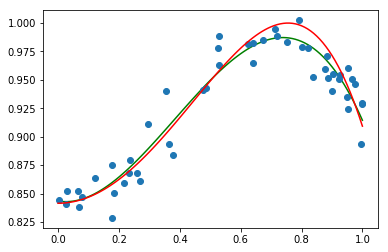

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def gen_sin(N=100, s=.03):
    """
    Generate random sinusoidal data.
    Args:
        N (int): number of samples to generate
        s (float): variance of noise
    Returns:
        X (float ndarray): randomly generated x values
        t (float ndarray): sinusoidal target values with Gaussian noise
    """
    X = np.random.rand(N, 1)
    noise = s * np.random.randn(N, 1)
    t = np.sin(1 + X**2) + noise
    return X, t

def plot_sin_data(fig, X=None, t=None):
    """
    Plots sinusoidal data.
    Args:
        fig (figure): figure to plot on
        X (float ndarray): x values to plot
        t (float ndarray): target values to plot
    """
    # Plot points
    if X is not None and t is not None: fig.plot(X, t, 'o')
    # Plot curve
    x_coords = np.arange(0, 1.01, .01)
    y_coords = np.sin(1 + x_coords ** 2)
    fig.plot(x_coords, y_coords, 'r-')

class KernelRegression:
    def __init__(self, X, t, method='normal', lam=0, kernel_name='gaussian', **kwargs):
        """
        Initialize kernel regression object.
        Args:
            X (float ndarray): training x values
            t (float ndarray): target values
            method (string): choose from normal (using normal equation) or NW (Nadaraya-Watson)
            lam (float): regularization coefficient (for normal method)
            kernel_name (string): name of kernel
            **kwargs: parameters for kernel
        """
        self.X = X
        self.t = t
        self.method = method
        kernel_util = KernelUtil(kernel_name, **kwargs)
        self.k = kernel_util.kernel
        self.K = kernel_util.gram(self.X)
        self.N = self.K.shape[0]
        self.lam = lam

    def _norm_eq(self):
        """
        Maximum likelihood solution via normal equations.
        Returns:
            a (float ndarray): 'weights'
        """
        a = np.linalg.pinv(self.K + self.lam*np.identity(self.N)).dot(self.t)
        return a

    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            (float): the predicted value 
        """
        if self.method == 'normal':
            a = self._norm_eq()
            k_vec = self.k(x, self.X)
            return k_vec.T.dot(a)[0]
        if self.method == 'NW':
            total = np.sum(self.k(x.T, self.X))
            return np.sum(self.k(x.T, self.X) * self.t) / total
        raise ValueError('method not normal or NW')


X, t = gen_sin(N=50, s=.015)
reg = KernelRegression(X, t, method='normal', kernel_name='polynomial', M=3)

x_coords = np.arange(0, 1.01, .01)
y_coords = [reg.pred(np.asarray([[x]]))[0] for x in x_coords]
plt.plot(x_coords, y_coords, 'g-')

plot_sin_data(plt, X, t)
plt.show()

Here is the same example with a Gaussian kernel, which is defined by $k(\vec{x},\vec{x}')=e^{-\frac{||\vec{x}-\vec{x}'||}{2\sigma^2}}$

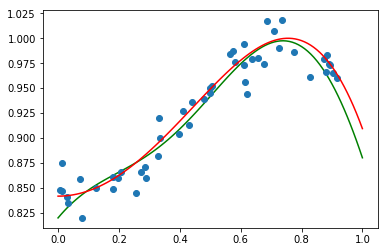

In [3]:
X, t = gen_sin(N=50, s=.015)
reg = KernelRegression(X, t, method='normal', lam=0.1, kernel_name='gaussian', gamma=3)

x_coords = np.arange(0, 1.01, .01)
y_coords = [reg.pred(np.asarray([[x]]))[0] for x in x_coords]
plt.plot(x_coords, y_coords, 'g-')

plot_sin_data(plt, X, t)
plt.show()

## Radial Basis Function Networks

Radial basis functions have the property that each basis function depends only on the radial distance from a center $\mathbf{\mu}_j$ so that $\phi_j(\vec{x})=h(||\vec{x}-\vec{\mu}_j||)$.

### Nadaraya-Watson model

The Nadaraya-Watson model uses the kernel as a local weighting function on $\vec{x}$ in order to estimate $t$. It's based on kernel density estimation. Suppose we have a training set ${x_n, t_n}$. We estimate the joint distribution $p(\vec{x}, t)$ by
$$p(\vec{x},t)=\frac{1}{N}\sum_{n=1}^Nf(\vec{x}-\vec{x}_n,t-t_n)$$
where $f(\vec{x},t)$ is the component density function with one component centered on each data point. <br>
In the example below, we use a Gaussian as the component density function. Given this, we can express the regression function as
$$y(\vec{x})=\mathbb{E}[t|\vec{x}]=\int_{-\infty}^{\infty}tp(t|\vec{x})dt=\frac{\int tp(\vec{x},t)dt}{\int p(\vec{x},t)dt}=\frac{\sum_n\int tf(\vec{x}-\vec{x}_n,t-t_n)dt}{\sum_m{\int f(\vec{x}-\vec{x}_m,t-t_m)dt}}$$
If we assume that the component density functions have zero mean so that $\int_{-\infty}^{\infty}f(\vec{x},t)tdt=0$, we can simplify this to
$$y(\vec{x})=\frac{\sum_n g(\vec{x}-\vec{x}_n)t_n}{\sum_m g(\vec{x}-\vec{x}_m)}=\sum_nk(\vec{x},\vec{x}_n)t_n$$
where the kernel function is given by
$$k(\vec{x},\vec{x}_n)=\frac{g(\vec{x}-\vec{x}_n)}{\sum_mg(\vec{x}-\vec{x}_m)}$$
and 
$$g(\vec{x})=\int_{-\infty}^{\infty}f(\vec{x},t)dt$$
Note that the kernel must satisfy
$$\sum_{n=1}^Nk(\vec{x},\vec{x}_n)=1$$
The functions for the Nadaraya Watson model are already implemented in the KernelRegression object above.

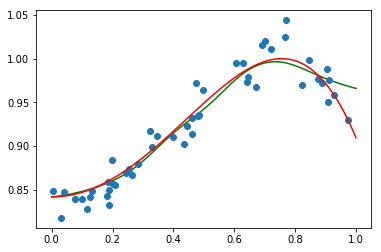

In [4]:
X, t = gen_sin(N=50, s=.015)
reg = KernelRegression(X, t, method='NW', kernel_name='gaussian', gamma=50)

x_coords = np.arange(0, 1.01, .01)
y_coords = [reg.pred(np.asarray([[x]])) for x in x_coords]
plt.plot(x_coords, y_coords, 'g-')

plot_sin_data(plt, X, t)
plt.show()

A full conditional distribution is given by $$p(t|\vec{x})=\frac{p(t,\vec{x})}{\int p(t,\vec{x})dt}=\frac{\sum_n f(\vec{x}-\vec{x}_n, t-t_n)}{\sum_m\int f(\vec{x}-\vec{x}_m, t-t_m)dt}$$

## Gaussian Processes

Gaussian processes apply kernels to probabilistic discriminative models. We dispose of the parameter $\vec{w}$ and directly predict the function $y$.

### Gaussian Processes for Regression

Previously, we had $y(\vec{x})=\vec{w}^T\phi(\vec{x})$, where $p(\vec{w})=\mathcal{N}(\vec{w}|\vec{0},\alpha^{-1}\mathbf{I})$. If we are given a training set, then $$\mathbf{y} = \Phi\vec{w}$$ where $\mathbf{y}=(y(\vec{x}_1),...,y(\vec{x}_N))^T$ and $\Phi$ is the design matrix. We observe that $\mathbf{y}$ is a linear combination of Gaussian varaibles, so $\mathbf{y}$ itself is Gaussian. The mean and covariance of $\mathbf{y}$ are given by
$$\mathbb{E}[\mathbf{y}]=\Phi\mathbb{E}[\vec{w}]=\vec{0}$$
$$\text{cov}[\mathbf{y}]=\mathbb{E}[\mathbf{y}\mathbf{y}^T]=\Phi\mathbb{E}[\mathbf{w}\mathbf{w}^T]\Phi^T=\frac{1}{\alpha}\Phi\Phi^T=\mathbf{K}$$
where $\mathbf{K}$ is the Gram matrix with elements $K_{mn}=k(\vec{x}_n,\vec{x}_m)=\frac{1}{\alpha}\phi(\vec{x}_n)^T\phi(\vec{x}_m)$ and $k(\vec{x},\vec{x}')$ is the kernel function. <br> <br>
Suppose we are given observed target values which have Gaussian noise of variance $\beta^-1$. Then for each observation, we have $p(t_n|y_n)=\mathcal{N}(t_n|y_n,\beta^-1)$ so that the entire dataset is given by
$$p(\mathbf{t}|\mathbf{y})=\mathcal{N}(\mathbf{t}|\mathbf{y},\beta^{-1}\mathbf{I}_N)$$
From above, we have $p(\mathbf{y})=\mathcal{N}(\mathbf{y}|\vec{0},\mathbf{K})$. Using results from section 2.3.3, we can find the marginal distribution $p(\mathbf{t})$, which gives us
$$p(\mathbf{t})=\int p(\mathbf{t}|\mathbf{y}d\mathbf{y}=\mathcal{N}(\mathbf{t}|\vec{0},\mathbf{C})$$
where $\mathbf{C}$ is the covariance with elements $C(\vec{x}_n,\vec{x}_m)=k(\vec{x}_n,\vec{x}_m)+\beta^{-1}\delta_{nm}$. <br> <br>
We want to find the predictive distribution $p(t_{N+1}|\mathbf{t}_N)$ (conditioned on $\vec{x}_1,...,\vec{x}_N,\vec{x}_{N+1}$). The joint distribution over $t_1,...,t_N,t_{N+1}$ is given by
$$p(\mathbf{t}_{N+1})=\mathcal{N}(\mathbf{t}_{N+1}|\vec{0},\mathbf{C}_{N+1})$$
where $C_{N+1}=\begin{bmatrix}
    \mathbf{C}_N       &\vec{k}\\
    \vec{k}^T       & c\\
\end{bmatrix}$ where $\mathbf{C}_N$ is the covariance matrix for the dataset with $N$ training points, and $\vec{k}$ is a vector with elements $k(\vec{x}_n,\vec{x}_{N+1})$ for $n=1,...,N$, and $c=k(\vec{x}_{N+1},\vec{x}_{N+1})+\beta^{-1}$. <br> Using results from 2.3.1, we find the conditional [predictive] distribution $$p(t_{N+1}|\mathbf{t})=\mathcal{N}(m(x_{N+1},\sigma^2(\vec{x}_{N+1}))$$ where $m(\vec{x}_{N+1})=\vec{k}^T\mathbf{C}_N^{-1}\mathbf{t}$ and $\sigma^2(\vec{x}_{N+1})=c-\vec{k}^T\mathbf{C}_N^{-1}\vec{k}$. <br>
In the example below, we use a frequently used kernel for Gaussian processes,
$$k(\vec{x}_n,\vec{x}_n)=\theta_0e^{-\frac{\theta_1}{2}||\vec{x}_n-\vec{x}_m||^2}+\theta_2+\theta_3\vec{x}^T_n\vec{x}_m$$

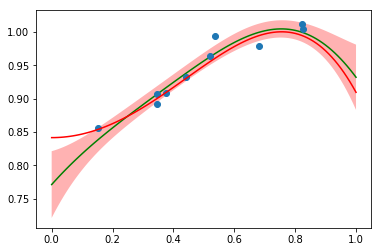

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm as sv_gauss
from scipy.optimize import minimize

class GPR:
    def __init__(self, X, t, beta=100, **kwargs):
        """
        Initializes Gaussian Process Regression object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values
            beta (float): noise precision
            **kwargs: parameters for combined kernel
        """
        self.X = X
        self.t = t
        self.beta = beta
        kernel_util = KernelUtil('combined', **kwargs)
        self.k = kernel_util.kernel
        self.K = kernel_util.gram(self.X)
        self.C = self.K + 1/beta * np.identity(self.K.shape[0])

    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            (float): the predicted value 
        """
        k_vec = self.k(x, self.X)
        return k_vec.T.dot(np.linalg.pinv(self.C)).dot(self.t)[0]
    
    def pred_dist(self, x):
        """
        Generates a predictive distribution.
        Args:
            x (float ndarray): value to evaluate predictive distribution at
        Returns:
            pred_dist (sv_gauss): predictive distribution at x
        """
        k_vec = self.k(x, self.X)
        m = k_vec.T.dot(np.linalg.pinv(self.C)).dot(self.t)[0]
        c = self.k(x, x) + 1/self.beta
        v = c - k_vec.T.dot(np.linalg.inv(self.C)).dot(k_vec)[0]
        pred_dist = sv_gauss(m.ravel(), v)
        return pred_dist

X, t = gen_sin(10, s=.015)
reg = GPR(X, t)

x_coords = np.arange(0, 1.01, .01)
y_coords = [reg.pred(np.asarray([[x]])) for x in x_coords]
plt.plot(x_coords, y_coords, 'g-')

p_low, p_hi = [], []
for x in x_coords:
    p = reg.pred_dist(np.asarray([[x]]))
    p_low.append(p.mean()-p.std())
    p_hi.append(p.mean()+p.std())
p_low, p_hi = np.array(p_low).ravel(), np.array(p_hi).ravel()
plt.fill_between(x_coords, p_low, p_hi, facecolor='red', alpha=0.3)

plot_sin_data(plt, X, t)
plt.show()

We can also learn the optimal hyperparameters by maximizing the likelihood function $p(\mathbf{t}|\theta)$ where $\theta$ denotes the hyperparameters. The log likelihood is given as
$$\log{p(\mathbf{t}|\theta)}=-\frac{1}{2}\log{|\mathbf{C}_N|}-\frac{1}{2}\mathbf{t}^T\mathbf{C}_N^{-1}\mathbf{t}-\frac{N}{2}\log{2\pi}$$
If we want to use a gradient based optimization methods, we have the derivative w.r.t. $\theta_i$ as
$$\frac{\partial}{\partial\theta_i}\log{p(\mathbf{t}|\vec{\theta})} = -\frac{1}{2}\text{Tr}\left(\mathbf{C}_N^{-1}\frac{\partial\mathbf{C}_N}{\partial\theta_i}\right) + \frac{1}{2}\mathbf{t}^T\mathbf{C}_N^{-1}\frac{\partial\mathbf{C}_N}{\partial\theta_i}\mathbf{C}_N^{-1}\mathbf{t}$$

beta 2733.79512697


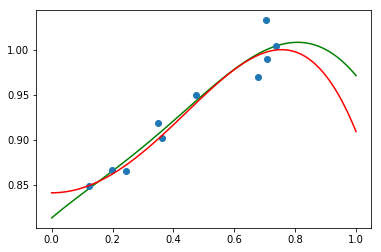

In [6]:
from scipy.optimize import minimize

class GPRWithOptimalBeta(GPR):
    def _optimize_beta(self):
        """
        Optimizes hyperparameter beta.
        """
        def log_likelihood(beta):
            N = self.K.shape[0]
            self.C = self.K + 1/beta*np.identity(N)
            ll = -0.5 * np.log(np.linalg.det(self.C)) \
                 -0.5 * self.t.T.dot(np.linalg.pinv(self.C)).dot(self.t) \
                 -N/2*np.log(2*np.pi)
            return -ll[0][0]
        self.beta = minimize(log_likelihood, self.beta).x[0]

X, t = gen_sin(10, s=.015)

reg = GPRWithOptimalBeta(X, t)
reg._optimize_beta()
print('beta', reg.beta)

x_coords = np.arange(0, 1.01, .01)
y_coords = [reg.pred(np.asarray([[x]])) for x in x_coords]
plt.plot(x_coords, y_coords, 'g-')

plot_sin_data(plt, X, t)
plt.show()


### Gaussian Processes for Classification

We can use Gaussian processes for classification by transforming the output of a Gaussian process for classification. For two classes, we first define a Gaussian process over a function $a(\vec{x})$ and transforming using the logistic sigmoid $y=\sigma(a)$. Suppose we have a training set with inputs $\vec{x}_1,...,\vec{x}_N$ and outputs $\mathbf{t}=(t_1,...,t_N)^T$. We want to determine the predictive distribution $p(t_{N+1}=1|\mathbf{t})$, since we only have 2 classes. We know the Gaussian process prior for $\vec{a}_{N+1}$ is given by
$$p(\vec{a}_{N+1})=\mathcal{N}(\vec{a}_{N+1}|\vec{0},\mathbf{C}_{N+1})$$
where $\mathbf{C}_{N+1}$ the same as defined above for Gaussian process regression. The predictive distirbution is given by
$$p(t_{N+1}=1|\mathbf{t})=\int p(t_{N+1}=1|a_{N+1})p(a_{N+1}|\mathbf{t}_N)da_{N+1}=\int \sigma(a_{N+1})p(a_{N+1}|\mathbf{t}_N)da_{N+1}$$
We have $p(a_{N+1}|\mathbf{t}_N)=\int p(a_{N+1}|\vec{a}_N)\ p(\vec{a}_N|\mathbf{t}_N)\ d\vec{a}_N$, and we know that $p(a_{N+1}|\vec{a}_N)=\mathcal{N}(a_{N+1}|\vec{k}^T\mathbf{C}_N^{-1}\vec{a}_N,c-\vec{k}^T\mathbf{C}_N^{-1}\vec{k})$. <br> We can find $p(\vec{a}_N|\mathbf{t}_N)$ by Laplace approximation. The prior $p(\vec{a}_N)=\mathcal{N}(\vec{a}_N|\vec{0},\mathbf{C}_N)$ and likelihood $p(\mathbf{t}_N|\vec{a}_n)=\prod_{n=1}^N\sigma(a_n)^{t_n}(1-\sigma(a_n))^{1-t_n}$ gives us the posterior, so the log posterior is
$$\log{p(\vec{a}_N|\mathbf{t}_N)}=-\frac{1}{2}\vec{a}_N^T\mathbf{C}_N^{-1}\vec{a}_N-\frac{N}{2}\log{2\pi}-\frac{1}{2}\log{|\mathbf{C}_N|}+\mathbf{t}_N^T\vec{a}_N-\sum_{n=1}^N\log{(1+e^{a_n})}$$
The first and second order gradients are given by
$$\nabla\log{p(\vec{a}_N|\mathbf{t}_N)}=\mathbf{t}_N-\vec{\sigma}_N-\mathbf{C}_N^{-1}\vec{a}_N$$
$$\nabla\nabla\log{p(\vec{a}_N|\mathbf{t}_N)}=-\mathbf{W}_N-\mathbf{C}_N^{-1}$$
where $\vec{\sigma}_N$ is a vector with elements $\sigma(a_N)$. We can now use Newton-Raphson to optimize $\vec{a}_N$. 
$$\vec{a}_N^{new}=\mathbf{C}_N(\mathbf{I}+\mathbf{W}_N\mathbf{C}_N)^{-1}(\mathbf{t}_N-\vec{\sigma}_N+\mathbf{W}_N\vec{a}_N^{old})$$
Hence, we have approximated $p(\vec{a}_N|\mathbf{t}_N)$ as $\mathcal(\vec{a}_N|\vec{a}_N^*,\mathbf{H}^{-1})$ where $\mathbf{H}=-\nabla\nabla\log{p(\vec{a}_N|\mathbf{t}_N)}=\mathbf{W}_N+\mathbf{C}_N^{-1}$. <br>
Now we have $p(a_{N+1}|\mathbf{t}_N)= \mathcal{N}(\vec{k}^T(\mathbf{t}_N-\vec{\sigma}_N), c-\vec{k}^T(\mathbf{W}_N^{-1}+\mathbf{C}_N)^{-1}\vec{k})$. We can now approximate $p(t_{N+1}=1|\mathbf{t}_N)$ as we did in Bayesian logistic regression. $\left(\int \sigma(a)\mathcal{N}(a|\mu,\sigma^2)da\simeq\sigma(\kappa(\sigma^2)\mu)\text{ where } \kappa(\sigma^2)=(1+\frac{\pi}{8}\sigma^2)^{-\frac{1}{2}}\right)$

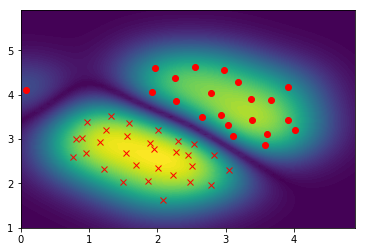

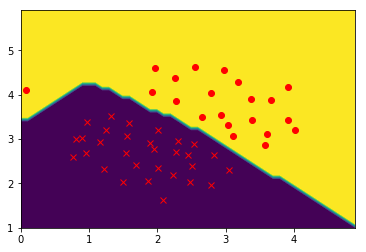

In [7]:

class BinaryGPC:
    def __init__(self, X, t, nu=.015, **kwargs):
        """
        Initializes Binary Gaussian Process classification object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values (t:{0, 1})
            nu (float): noise-like hyperparameter
            **kwargs: parameters for combined kernel
        """
        self.X = X
        self.t = t
        self.nu = nu
        kernel_util = KernelUtil('combined', **kwargs)
        self.k = kernel_util.kernel
        self.K = kernel_util.gram(self.X)
        self.N = self.K.shape[0]
        self.C = self.K + nu * np.identity(self.K.shape[0])
        self.a_N = None

    def _sigmoid(self, a):
        """
        Sigmoid function.
        Args:
            a (float ndarray): input value
        Returns:
            (float): sigmoidal value of a
        """
        return 1/(1+np.exp(-a))

    def fit(self, maxiter=1000):
        """
        Computes weight parameters.
        Returns:
            a_N (float ndarray): weight parameters
        """
        self.a_N = np.random.randn(self.N, 1)
        for _ in range(maxiter):
            self.W = np.diag((self._sigmoid(self.a_N) * (1 - self._sigmoid(self.a_N))).ravel())
            self.a_N = self.C.dot(np.linalg.pinv(np.identity(self.N) + \
                       self.W.dot(self.C))).dot(self.t-self._sigmoid(self.a_N) + \
                       self.W.dot(self.a_N))
        return self.a_N
    
    def pred(self, x):
        """
        Predicts class for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.a_N is not None, 'Need to fit first.'
        k_vec = self.k(x.T, self.X)
        m = k_vec.T.dot(self.t - self._sigmoid(self.a_N))
        c = self.k(x.T, x)
        v = c-k_vec.T.dot(np.linalg.pinv(np.linalg.inv(self.W)+self.C)).dot(k_vec)
        p_C1 = self._sigmoid(m * (1+np.pi/8 * c) ** (-0.5))
        pred, val = np.round(p_C1), np.abs(p_C1 - (p_C1 < 0.5))
        return pred, val


def plot_c_data(fig, X, t):
    """
    Plots classification data.
    Args:
        fig (figure): figure to plot on
        X (float ndarray): x values to plot
        t (float ndarray): corresponding classes to X
    """
    markers = ['rx', 'ro', 'r+', 'r^', 'r.']
    for i, c in enumerate(np.unique(t)):
        fig.plot(X[np.where(t==c)[0], [0]], X[np.where(t==c)[0], [1]], markers[i])
    
    
def plot_contour(fig, x_coord, y_coord, clas, grad=True, levels=100):
    """
    Plots contours for classification data.
    Args:
        fig (figure): figure to plot on
        x_coord (float iterable): x coordinate range
        y_coord (float iterable): y coordinate range
        clas (classifier): classifier object with 'pred' function
    """
    X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
    Z_coord = np.zeros(X_coord.shape)
    for i in range(X_coord.shape[0]):
        for j in range(X_coord.shape[1]):
            x = np.asarray([[X_coord[i, j], Y_coord[i, j]]])
            Z_coord[i, j] = clas.pred(x)[grad]
    fig.contourf(X_coord, Y_coord, Z_coord, levels)


def plot_contour_both(fig, x_coord, y_coords, clas):
    """
    Plots contour for classification both with and without gradient.
    Args:
        fig (figure): figure to plot on
        x_coord (float ndarray): x values to plot
        y_coord (float ndarray): y values to plot
        clas (classifier): classifier with pred functions
    """
    plot_contour(fig, x_coord, y_coord, clas)
    plot_c_data(fig, X, t)
    fig.show()
    plot_contour(fig, x_coord, y_coord, clas, grad=False)
    plot_c_data(fig, X, t)
    fig.show()


file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1t.csv'

X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

clas = BinaryGPC(X, t)
clas.fit()
    
x_coord = np.arange(0, 5, 0.1)
y_coord = np.arange(1, 6, 0.1)

plot_contour_both(plt, x_coord, y_coords, clas)

## Support vector machines

### Classification

In support vector machines, we hope to find a decision boundary with the smallest generalization error through the concept of margin, which is the smallest distance between the decision boudnary and any sample. Suppose we have a binary classification problem with training data $\{\vec{x}_1,...,\vec{x}_N\}$ with target values $\{t_1,...,t_N\}$ where $t\in\{-1, 1\}$. We'd like to find a linear model where $y(\vec{x})=\vec{w}^T\vec{\phi(\vec{x})}+b$. The perpendicular distance of a point $\vec{x}$ to the hyperplane defined by $y(\vec{x})=0$ is given by $\frac{|y(\vec{x})|}{||\vec{w}||}$, and since we're only interested in correctly classified points (i.e. $t_ny(\vec{x}_n)>0$), we can simplify this to $\frac{t_ny(\vec{x}_n)}{||\vec{w}||}\Rightarrow\frac{t_n(\vec{w}^T\vec{\phi}(\vec{x}_n)+b)}{||\vec{w}||}$. <br>
The objective is to maximize the margin:
$$\text{argmax}_{\vec{w},b}=\left(\frac{1}{||\vec{w}||}\text{min}_n\left(t_n(\vec{w}^T\vec{\phi}(\vec{x}_n)+b)\right)\right)$$
Since scaling $\vec{w}$ and $b$ won't change the distance from $\vec{x}_n$ to the decision boundary, we can WLOG set $$t_n(\vec{w}^T\vec{\phi}(\vec{x}_n)+b)=1$$
Hence, our objective becomes
$$\text{argmax}_{\vec{w},b}(\frac{1}{||\vec{w}||})\Leftrightarrow\text{argmin}_{\vec{w},b}(\frac{1}{2}||\vec{w}||^2)$$
We now introduce slack variables $\xi\geq0$ for each training data points such that $\xi_n=0$ for data points on the correct side of the decision boundary, and $\xi_n=|t_n-y(\vec{x}_n)|$ otherwise. Our objective now becomes 
$$C\sum_{n=1}^N\xi_n+\frac{1}{2}||\vec{w}||^2$$
where $C>0$ controls trade-off between the slack variable penalty and the margin. We can think of it as the inverse regularization parameter.<br> 
Since we have constraints, we can exprress our objective with Lagrange multiplers.
$$L(\vec{w},b,\vec{\xi},\vec{a},\vec{\mu})=\frac{1}{2}||\vec{w}||^2-C\sum_{n=1}^N\xi-\sum_{n=1}^Na_n(t_ny(\vec{x}_n)-1+\xi)-\sum_{n=1}^N\mu_n\xi_n$$
If we find the critical points w.r.t. $\vec{w}$, $b$, and $\xi_n$ we obtain
$$\vec{w}: \vec{w}=\sum_{n=1}^Na_nt_n\vec{\phi}(\vec{x}_n)$$
$$b: 0=\sum_{n=1}^Na_nt_n$$
$$\xi_n: a_n=C-\mu_n$$
Substituting these back in yields the dual representation
$$\tilde{L}(\vec{a})=\sum_{n=1}^Na_n-\frac{1}{2}\sum_{n=1}^N\sum_{m=1}^Na_na_mt_nt_mk(\vec{x}_n,\vec{x}_m)$$
where $0\leq a_n\leq C$ and $\sum_{n=1}^Na_nt_n=0$, and $k$ is the kernel function. After finding $\vec{a}$, we can classify new data points with
$$y(\vec{x})=\sum_{n=1}^Na_nt_nk(\vec{x},\vec{x}_n)+b$$
where we can find $b$ through the support vectors; since $t_n(\sum_{m\in S}a_mt_mk(\vec{x}_n,\vec{x}_m)+b)=1$, we get
$$b=\frac{1}{N_M}\sum_{n\in M}(t_n-\sum_{m\in S}a_mt_mk(\vec{x}_n,\vec{x}_m))$$ where $M$ denotes the set of indices of the support vectors (i.e. $0<a_n<C$). <br>
We average all these estimates of $b$ for a numerically stable solution.<br>
Now we can minimize the above Lagrangian with the standard numerical optimization techniques, but since this is a quadratic programming problem, there are special libraries for quick optimization. These problems take the form
$$\frac{1}{2}\vec{x}^T\mathbf{P}\vec{x}+\vec{q}^T\vec{x}$$ 
$$\text{with } \mathbf{G}\vec{x}\leq\vec{h}$$
$$\text{and } \mathbf{A}\vec{x}=\vec{b}$$
Converting the Lagrangian to this quadratic form, we get 
$$\mathbf{Q}=tt^T*K  \text{ (}*\text{denotes element-wise multiplication)}$$
$$\vec{p}=[1,...,1] \text{ with N elements}$$
$$\mathbf{A} = tt^T$$
$$\vec{b}=[0]$$
$$\mathbf{G}=\begin{bmatrix}
    -N\times N \text{ identity}      \\
    N\times N \text{ identity}
\end{bmatrix}$$
$$\vec{h}=\begin{bmatrix}
    [1,...,1]^T \text{ with }N\text{ elements} \\
    [C,...,C]^T \text{ with }N\text{ elements} \\
\end{bmatrix}$$

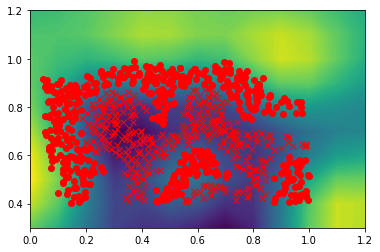

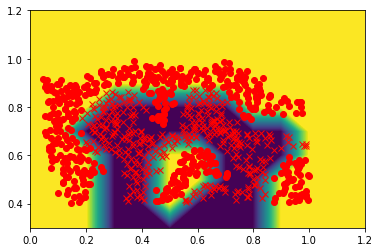

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import solvers, matrix

class SVMC:
    def __init__(self, X, t, C=3, kernel_name='gaussian', **kwargs):
        """
        Initializes Support Vector Machine classification object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values (t:{0, 1})
            C (float): 'inverse regularization coefficient'
            kernel_name (string): name of kernel ('gaussian', 'linear',...)
            **kwargs: parameters for kernel
        """
        self.X = X
        self.t = 2*(t==1) - 1  # convert to -1, 1
        kernel_util = KernelUtil(kernel_name, **kwargs)
        self.k = kernel_util.kernel
        self.K = kernel_util.gram(X)
        self.C = C
        self.a = None
        self.b = None
        
    def fit(self):
        """
        Fits data to model.
        Returns:
            a (float ndarray): weight parameters
            b (float): bias parameter
        """
        N = self.K.shape[0]
        Q = matrix(self.t.dot(self.t.T) * self.K)
        p = matrix(-np.ones((N, 1)))
        A = matrix(self.t.T.astype('float'))
        b = matrix(np.zeros(1))
        G = matrix(np.vstack((-np.identity(N), np.identity(N))))
        h = matrix(np.vstack((np.zeros((N, 1)), self.C * np.ones((N, 1)))))
        solvers.options['show_progress'] = False
        sol = solvers.qp(Q, p, G, h, A, b)
        self.a = np.asarray(sol['x'])
        sv_indices = np.where(self.a > 1e-5)[0]
        self.b = np.sum(self.t[sv_indices])
        for n in sv_indices:
            self.b -= (self.a[sv_indices]*self.t[sv_indices]).T.dot(self.K[n, [sv_indices]].reshape(-1, 1))[0]
        self.b /= len(sv_indices)
        return self.a, self.b
    
    def pred(self, x):
        """
        Predicts class for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.a is not None, 'Need to fit first'
        sv_indices = np.where(self.a > 1e-5)[0]
        y = np.sum(self.a * self.t * self.k(x.T, self.X)) + self.b
        pred, val = 1*(y > 0), y
        return pred, val

file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set3X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set3t.csv'

X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

clas = SVMC(X, t, kernel_name='gaussian')
clas.fit()
x_coord = np.arange(0, 1.3, 0.1)
y_coord = np.arange(.3, 1.3, 0.1)

plot_contour_both(plt, x_coord, y_coords, clas)

In the case of multiple classes, we can use the "1 vs the rest" approach, where we construct $K$ separate SVMs where for each $k$, one class is positive and all the others are negative.

### Regression

SVM for regression is very similar. We use a regularized error function
$$C\sum_{n=1}^NE_{\epsilon}(y(\vec{x}_n)-t_n)+\frac{1}{2}||\vec{w}||^2$$
where $E_{\epsilon}(y(\vec{x})-t)=
                    \begin{cases}
                      0 & \text{if}\ |y(\vec{x})-t|<\epsilon \\
                      |y(\vec{x})-t|-\epsilon & \text{else}
    \end{cases}$
for some specified $\epsilon$. We now need two sets of slack variables; $\xi_n\geq0$ corresponds to a point for which $t_n>y(\vec{x}_n)+\epsilon$ and $\hat{\xi}_n\geq0$ corresponds to a point for which $t_n<y(\vec{x}_n)-\epsilon$. We can now reformulate the error function to
$$C\sum_{n=1}^N(\xi_n+\hat{\xi}_n)+\frac{1}{2}||\vec{w}||^2$$
We proceed similarly like above with the Lagrangian stuff, and we eventually get a dual representation of 
$$\tilde{L}(\vec{a},\hat{\vec{a}})=-\frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N(a_n-\hat{a}_n)(a_m-\hat{a}_m)k(\vec{x}_n,\vec{x}_m)-\epsilon\sum_{n=1}^N(a_n+\hat{a}_n)+\sum_{n=1}^N(a_n-\hat{a}_n)t_n$$
After finding $\vec{a},\hat{\vec{a}}$, we can classify new data points using
$$y(\vec{x})=\sum_{n=1}^N(a_n-\hat{a}_n)k(\vec{x},\vec{x}_n)+b$$
where $b$ can be determined with the support vectors:
$$b=t_n-\epsilon-\sum_{n=1}^N(a_m-\hat{a}_m)k(\vec{x}_n,\vec{x}_m)\text{ for } 0<a_n<C$$
$$b=t_n+\epsilon-\sum_{n=1}^N(a_m-\hat{a}_m)k(\vec{x}_n,\vec{x}_m)\text{ for } 0<\hat{a}_n<C$$
We average these estimates of $b$ for a numerically stable solution. <br>
Again, we use quadratic programming to optimize. The parameters are given by
Converting the Lagrangian to this quadratic form, we get 
$$\mathbf{Q}=\begin{bmatrix}
    K & -K \\
    -K & K \\
\end{bmatrix}$$
$$\vec{p}=[\epsilon-t_1,...,\epsilon-t_N, \epsilon+t_1,...,\epsilon+t_N]$$
$$\mathbf{A} = [1,...,1,-1,...,-1] \text{ with }2N\text{ elements}$$
$$\vec{b}=[0]$$
$$\mathbf{G}=\begin{bmatrix}
    -2N\times 2N \text{ identity}      \\
    2N\times 2N \text{ identity}
\end{bmatrix}$$
$$\vec{h}=\begin{bmatrix}
    [1,...,1]^T \text{ with }2N\text{ elements} \\
    [C,...,C]^T \text{ with }2N\text{ elements} \\
\end{bmatrix}$$

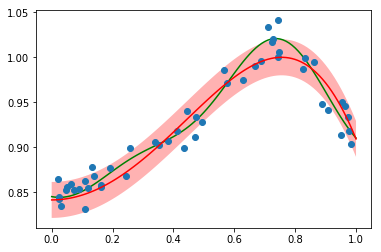

In [9]:
class SVMR:
    def __init__(self, X, t, eps=.02, C=3, kernel_name='gaussian', **kwargs):
        """
        Initializes Support Vector Machine classification object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values
            eps (float): epsilon
            C (float): 'inverse regularization coefficient'
            kernel_name (string): name of kernel ('gaussian', 'linear',...)
            **kwargs: parameters for kernel
        """
        self.X = X
        self.t = t
        kernel_util = KernelUtil(kernel_name, **kwargs)
        self.k = kernel_util.kernel
        self.K = kernel_util.gram(X)
        self.C = C
        self.eps = eps
        self.a = None
        self.b = None

    def fit(self):
        """
        Fits data to model.
        Returns:
            a (float ndarray): weight parameters
            b (float): bias parameter
        """
        N = self.K.shape[0]
        Q = matrix(np.hstack((np.vstack((self.K, -self.K)), np.vstack((-self.K, self.K)))))
        p = matrix(np.vstack((self.eps * np.ones((N, 1)) - self.t, self.eps * np.ones((N, 1)) + self.t)))
        A = matrix(np.hstack((np.ones((1, N)), -np.ones((1, N)))))
        b = matrix(np.zeros(1))
        G = matrix(np.vstack((-np.identity(2*N), np.identity(2*N))))
        h = matrix(np.vstack((np.zeros((2*N, 1)), self.C*np.ones((2*N, 1)))))
        solvers.options['show_progress'] = False
        sol = solvers.qp(Q, p, G, h, A, b)
        self.a = np.asarray(sol['x'])
        a1 = self.a[:N].reshape(-1, 1)
        a2 = self.a[N:].reshape(-1, 1)
        sv_indices = np.where(np.logical_or(a1 > 1e-5, a2 > 1e-5))[0]
        self.b = np.average([self.t[n] - self.eps - (a1 - a2).T.dot(self.K[n].reshape(-1, 1)) if self.a[n] > 1e-5
                             else self.t[n] + self.eps - (a1 - a2).T.dot(self.K[n].reshape(-1, 1)) for n in sv_indices])
        return self.a, self.b

    def pred(self, x):
        """
        Predicts target for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            y (float): the predicted value
        """
        assert self.a is not None, 'Need to fit first.'
        N = self.K.shape[0]
        a1 = self.a[:N].reshape(-1, 1)
        a2 = self.a[N:].reshape(-1, 1)
        sv_indices = np.where(np.logical_or(a1 > 1e-5, a2 > 1e-5))[0]
        y = np.sum((a1[sv_indices] - a2[sv_indices]) * self.k(x.T, self.X[sv_indices])) + self.b
        return y


eps = 0.02
X, t = gen_sin(50, s=.015)

reg = SVMR(X, t, eps=eps, kernel_name='gaussian')
reg.fit()

x_coords = np.arange(0, 1.01, .01)
y_coords = [reg.pred(np.asarray([[x]])) for x in x_coords]
plt.plot(x_coords, y_coords, 'g-')
shade_low = np.sin(1 + np.arange(0, 1.01, .01) ** 2) - eps
shade_hi = np.sin(1 + np.arange(0, 1.01, .01) ** 2) + eps
plt.fill_between(x_coords, shade_low, shade_hi, facecolor='red', alpha=0.3)
plot_sin_data(plt, X, t)
plt.show()



In the plot above, the red shading denotes the $\epsilon$ tube.

## Relevance vector machines

Relevance vector machines are similar to SVMs but in a Bayesian context. It avoids some limitations of SVMs since it is able to represent posterior probabilities, it is easy to extend to 2+ classes for classification, and parameters such as $C$, $\nu$ (for $\nu$-SVMs), and $\epsilon$ are automatically determined. RVM is also basically the same as Bayesian regression except that we have separate hyperparameters for each weight, instead of a shared hyperparameter for all the weights. This allows for a sparse model since we can determine which weights are useless through observing $\alpha$.

### Regression

Suppose we have a training set $\mathbf{X}=(\vec{x}_1^T,...,\vec{x}_N^T)^T$ with cooresponding targets $\mathbf{t}=(t_1,...,t_N)^T$. The prior and likelihood function are respectively given by
$$p(\vec{w}|\vec{\alpha})=\prod_{i=1}^M\mathcal{N}(w_i|0,\alpha_i^{-1})$$
$$p(\mathbf{t}|\mathbf{X},\vec{w},\beta)=\prod_{n=1}^Np(t_n|\vec{x}_n,\vec{w},\beta)=\prod_{n=1}^N\mathcal{N}(t_n|y(\vec{x}_n),\beta^{-1})$$
The posterior is then given by $$p(\vec{w}|\mathbf{t},\mathbf{X},\vec{\alpha}, \beta)=\mathcal{N}(\vec{w}|\vec{m},\Sigma)$$
where
$$\vec{m}=\beta\Sigma\Phi^T\mathbf{t}$$
$$\Sigma=(\mathbf{A}+\beta{\Phi}^T\Phi)^{-1}$$
$$\Phi \text{ is the design matrix}$$
$$\mathbf{A}=\text{diag}(\vec{\alpha})$$
Note that $\Phi$ can also be replaced with the Gram matrix, although we need to append 1s for the bias term. We can determine the hyperparameters $\vec{\alpha}$ and $\beta$ with type 2 maximum likelihood. Maximizing the log evidence yields the following re-estimations:
$$\alpha_i^{new}=\frac{\gamma}{m_i^2}$$
$$(\beta)^{-1}=\frac{||\vec{t}-\Phi\vec{m}||^2}{N-\sum_i\gamma_i}$$
where $\gamma_i=1-\alpha_i\Sigma_{ii}$. We learn these hyperparameters by initializing them, evaluating the mean and covariance of the posterior, and re-estimating these hyperparameters. We can also use the EM algorithm.

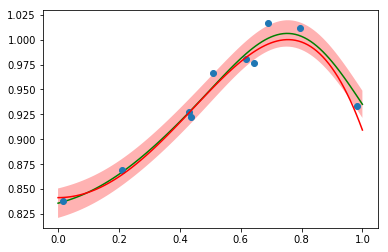

In [10]:
class RVMR:
    def __init__(self, X, t, beta=400, kernel_name='gaussian', **kwargs):
        """
        Initializes Relevance Vector Machine regression object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values
            beta (float): precision of noise
            kernel_name (string): name of kernel ('gaussian', 'linear',...)
            **kwargs: parameters for kernel
        """
        self.X = X
        self.t = t
        kernel_util = KernelUtil(kernel_name, **kwargs)
        self.k = kernel_util.kernel
        self.K = kernel_util.gram(X)
        self.K = np.hstack((np.ones((self.K.shape[0], 1)), self.K))
        self.N, self.D = self.K.shape
        self.beta = beta 
        self.m = None

    def fit(self, maxiter=100):
        """
        Fits data to model.
        Returns:
            alpha (float ndarray): prior covariances
            beta (float): noise precision
        """
        self.alpha = np.ones((self.D, 1))
        A = np.diag(self.alpha.ravel())
        for _ in range(maxiter):
            # Posterior parameter estimations
            self.cov = np.linalg.pinv(A + self.beta * self.K.T.dot(self.K))
            self.m = self.beta * self.cov.dot(self.K.T).dot(self.t)
            gamma = (1 - self.alpha * np.diagonal(self.cov).reshape(-1, 1))
            # Hyperparameter re-estimation
            self.alpha = gamma / self.m**2
            self.beta = (self.N - np.sum(gamma))/(np.linalg.norm(self.t-self.K.dot(self.m))**2)
            self.alpha[self.alpha>1e8]=1e8
            A = np.diag(self.alpha.ravel())
        return self.alpha, self.beta, self.m

    def pred(self, x):
        """
        Predicts target for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            (float): the predicted value 
        """
        assert self.m is not None, 'Need to fit first'
        k_vec = np.vstack((np.ones(1), self.k(x.T, self.X)))
        return self.m.T.dot(k_vec)[0]
    
    def pred_dist(self, x):
        """
        Generates a predictive distribution.
        Args:
            x (float ndarray): value to evaluate predictive distribution at
        Returns:
            pred_dist (sv_gauss): predictive distribution at x
        """
        assert self.m is not None, 'Need to fit first'
        A = np.diag(self.alpha.ravel())
        cov = np.linalg.pinv(A + self.beta*self.K.T.dot(self.K))
        k_vec = np.vstack((np.ones(1), self.k(x.T, X)))
        m = self.m.T.dot(k_vec)[0]
        v = 1/self.beta + k_vec.T.dot(cov).dot(k_vec)[0]
        pred_dist = sv_gauss(m.ravel(), v**0.5)
        return pred_dist

X, t = gen_sin(10, s=.015)

reg = RVMR(X, t, kernel_name='gaussian')
reg.fit()

x_coords = np.arange(0, 1.01, .01)
y_coords = [reg.pred(np.asarray([[x]])) for x in x_coords]
plt.plot(x_coords, y_coords, 'g-')

p_low, p_hi = [], []
for x in x_coords:
    p = reg.pred_dist(np.asarray([[x]]))
    p_low.append(p.mean()-p.std())
    p_hi.append(p.mean()+p.std())
p_low, p_hi = np.array(p_low).ravel(), np.array(p_hi).ravel()
plt.fill_between(x_coords, p_low, p_hi, facecolor='red', alpha=0.3)

plot_sin_data(plt, X, t)
plt.show()

The predictive distribution is given by
$$p(t|\vec{x},\mathbf{X},\mathbf{t},\alpha^*,\beta^*)=\int p(t|\vec{x},\vec{w},\beta^*)p(\vec{w}|\mathbf{X},\vec{t},\vec{\alpha}^*,\beta^*)d\vec{w}=\mathcal{N}(t|\vec{m}^T\vec{\phi}(\vec{x}),\sigma^2(\vec{x}))$$
where $\sigma^2(\vec{x})={\beta^*}^{-1}+\vec{\phi}(\vec{x})^T\Sigma\vec{\phi}(\vec{x})$ and $\Sigma=(\mathbf{A}^*+\beta^*\Phi^T\Phi)^{-1}$ and $\mathbf{A}^*=\text{diag}(\vec{\alpha})$.

### Classification

RVM classification is very similar to RVM regression, just with a sigmoid function. We have to approximate the posterior now since the sigmoid makes it analytically intractable. We hope to maximize the log posterior, given by
$$\log{p(\vec{w}|\mathbf{t},\vec{\alpha})=\log\left(p(\mathbf{t}|\vec{w})p(\vec{w}|\vec{\alpha})\right)}-\log{p(\mathbf{t}|\vec{\alpha})}=\sum_{n=1}^N\left(t_n\log{y_n}+(1-t_n)\log{(1-y_n)}\right)-\frac{1}{2}\vec{w}^T\mathbf{A}\vec{w}+\text{ const }$$
We can use IRLS to find the mode. The gradient and the Hessian are given as follows:
$$\nabla\log{p(\vec{w}|\mathbf{t},\vec{\alpha})}=\Phi^T(\mathbf{y}-\mathbf{t})-\mathbf{A}\vec{w}$$
$$\nabla\nabla p(\vec{w}|\mathbf{t},\vec{\alpha})=-(\Phi^T\mathbf{B}\Phi+\mathbf{A})$$ where $\mathbf{B}=\text{diag}(\mathbf{y}*(1-\mathbf{y}))$ where $*$ is element-wise multiplication. After finding an optimal $\vec{w}$ for a fixed $\alpha$, we then re-estimate $\alpha$, and then go back and forth. By setting the evidence function's derivative to 0, we get
$$\alpha_i^{new}=\frac{\gamma_i}{(w_i^*)^2}$$
where $\gamma_i=1-\alpha_i\Sigma_{ii}$.

For classification problems with more than 2 classes, we can just use the softmax function instead of the sigmoid function.

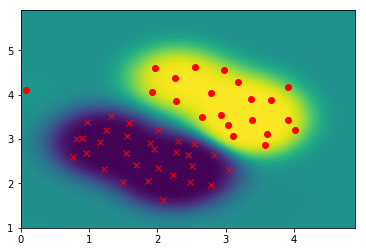

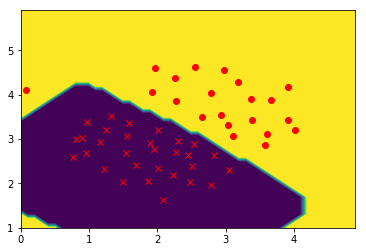

In [11]:
import numpy as np
import matplotlib.pyplot as plt


class RVMC:
    def __init__(self, X, t, kernel_name='gaussian', **kwargs):
        """
        Initializes Relevance Vector Machine regression object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values (t:{0, 1,...})
            kernel_name (string): name of kernel ('gaussian', 'linear',...)
            **kwargs: parameters for kernel
        """
        self.X = X
        self.t = t
        kernel_util = KernelUtil(kernel_name, **kwargs)
        self.k = kernel_util.kernel
        self.K = kernel_util.gram(X)
        self.K = np.hstack((np.ones((self.K.shape[0], 1)), self.K))
        self.N, self.D = self.K.shape
        self.m = None

    def _sigmoid(self, a):
        """
        Sigmoid function.
        Args:
            a (float ndarray): input value
        Returns:
            (float): sigmoidal value of a
        """
        return 1/(1 + np.exp(-a))

    def _optimize_posterior(self, maxiter=10):
        """
        Sigmoid function.
        Args:
            maxiter (int): maximum number of iterations
        Returns:
            m (float): mean of posterior
            cov (float ndarray): covariance of posterior
        """
        A = np.diag(self.alpha.ravel())
        m = np.zeros((self.D, 1))
        for _ in range(maxiter):
            y = self._sigmoid(self.K.dot(m))
            grad = self.K.T.dot(self.t - y) - A.dot(m)
            B = np.diag((y * (1 - y)).ravel())
            hess = -(self.K.T.dot(B).dot(self.K) + A)
            m -= np.linalg.pinv(hess).dot(grad)
        cov = np.linalg.pinv(-hess)
        return m, cov

    def fit(self, maxiter=10):
        """
        Fits data to model.
        Args:
            maxiter (int): maximum number of iterations
        Returns:
            alpha (float ndarray): optimized alpha values
        """
        self.alpha = np.ones((self.D, 1))
        for _ in range(maxiter):
            m, cov = self._optimize_posterior()
            self.alpha = (1-self.alpha*np.diagonal(cov).reshape(-1, 1))/m**2
            self.alpha[self.alpha>1e8]=1e8
        self.m = m
        self.cov = cov
        return self.alpha, self.m
    
    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.m is not None, 'Need to fit first'
        k_vec = np.vstack((np.ones(1), self.k(x.T, self.X)))
        y = self._sigmoid(self.m.T.dot(k_vec)[0])
        pred, val = 1*(y>0.5), y
        return pred, val


file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1t.csv'

X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)


clas = RVMC(X, t, kernel_name='gaussian', gamma=3)
clas.fit()

x_coord = np.arange(0, 5, 0.1)
y_coord = np.arange(1, 6, 0.1)

plot_contour_both(plt, x_coord, y_coord, clas)
